In [14]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.25.1


In [15]:
rng = np.random.seed(2741)
az.style.use("arviz-darkgrid")

In [16]:
try:
    d = pd.read_csv(os.path.join("..", "data", "body_fat.csv"))
except FileNotFoundError:
    d = pd.read_csv(pm.get_data("body_fat.csv"))

d.head()

,siri,age,weight,height,neck,chest,abdomen,hip,thigh,knee,ankle,biceps,forearm,wrist
0,12.3,23,70.1,172,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.1,22,78.8,184,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,25.3,22,70.0,168,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.4,26,84.0,184,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,28.7,24,83.8,181,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


Text(0.5, 0, 'weight')

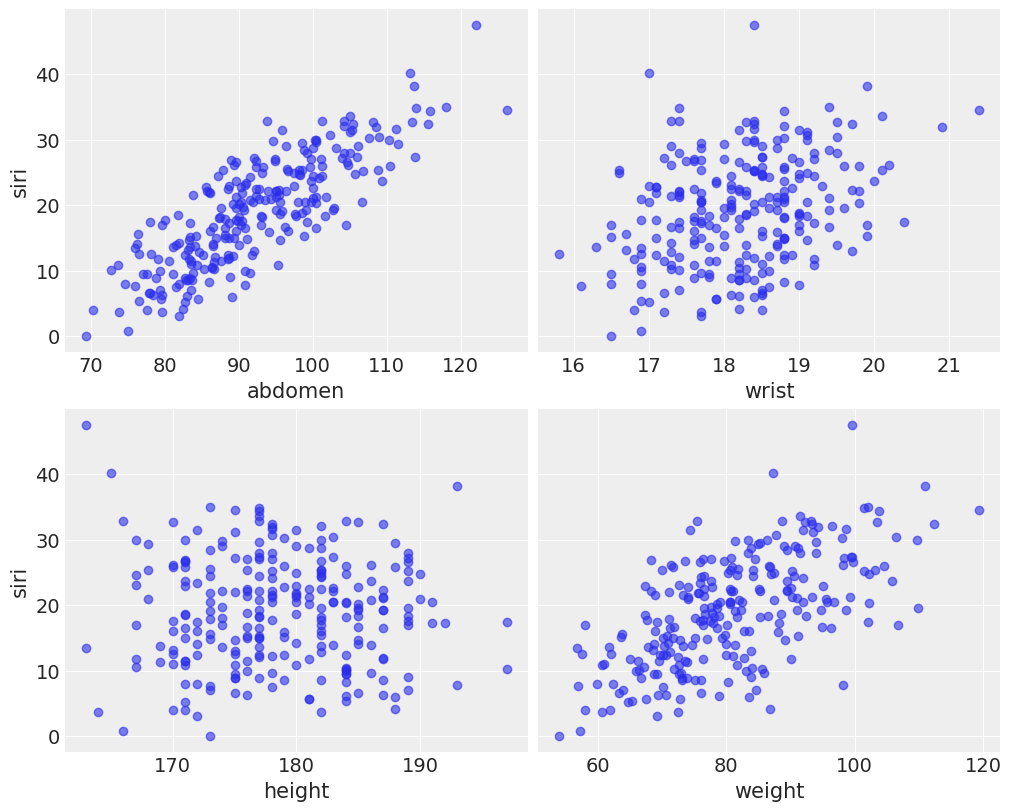

In [37]:
fig, axes = plt.subplots(2, 2, sharey=True, figsize=(10, 8))
axes[0][0].scatter(d['abdomen'], d['siri'], alpha=0.6)
axes[0][1].scatter(d['wrist'], d['siri'], alpha=0.6)
axes[1][0].scatter(d['height'], d['siri'], alpha=0.6)
axes[1][1].scatter(d['weight'], d['siri'], alpha=0.6)
axes[0][0].set_ylabel("siri")
axes[1][0].set_ylabel("siri")
axes[0][0].set_xlabel("abdomen")
axes[0][1].set_xlabel("wrist")
axes[1][0].set_xlabel("height")
axes[1][1].set_xlabel("weight")

In [17]:
with pm.Model() as model_0:
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", 5)

    mu = alpha + beta * d["abdomen"]

    siri = pm.Normal("siri", mu=mu, sigma=sigma, observed=d["siri"])

    idata_0 = pm.sample(idata_kwargs={"log_likelihood": True}, random_seed=rng)
    pm.sample_posterior_predictive(idata_0, extend_inferencedata=True, random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [siri]


Output()

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

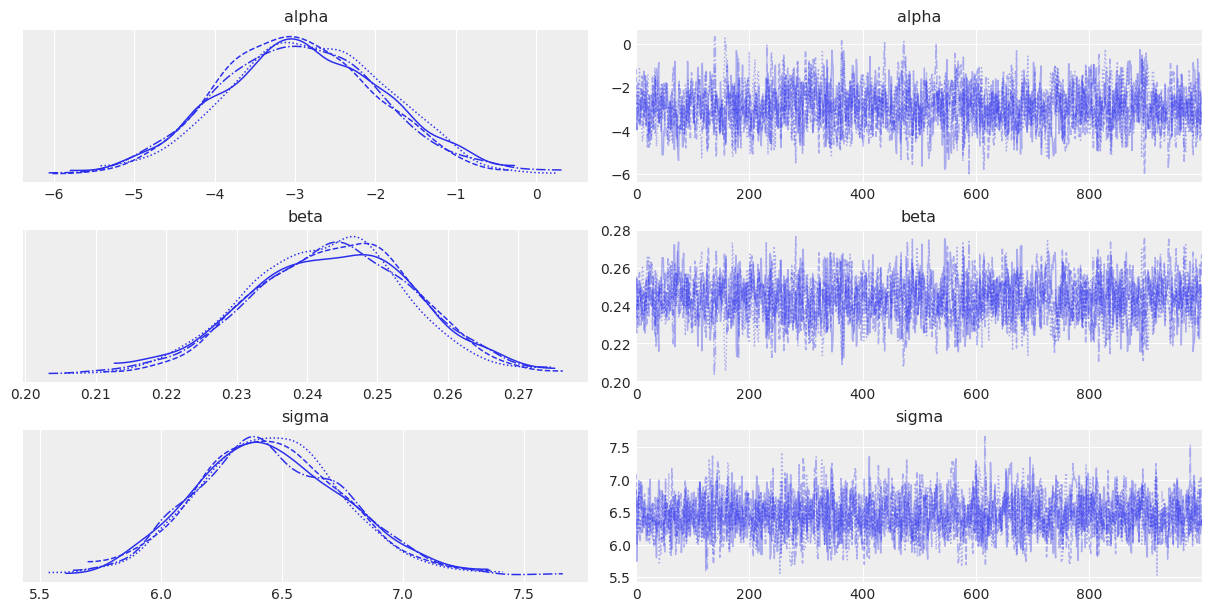

In [18]:
az.plot_trace(idata_0)

Sampling: [siri]


Output()

<Axes: xlabel='siri'>

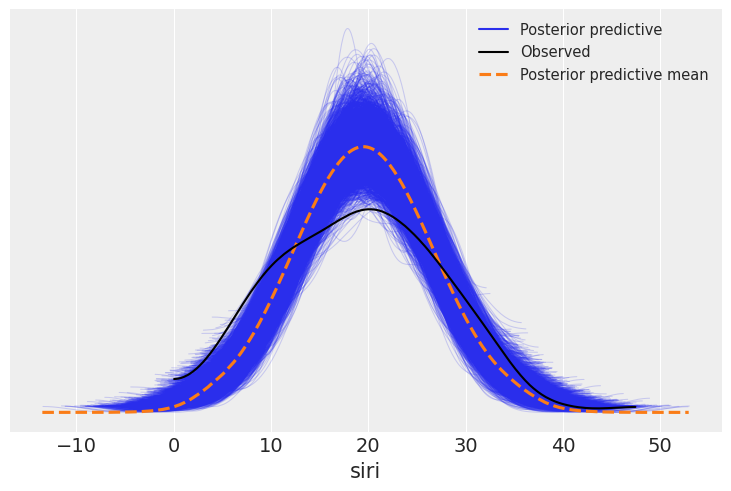

In [19]:
with model_0:
    pm.sample_posterior_predictive(idata_0, extend_inferencedata=True, random_seed=rng)
az.plot_ppc(idata_0)

In [20]:
with pm.Model() as model_1:
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1, shape=3)
    sigma = pm.HalfNormal("sigma", 5)

    mu = alpha + pm.math.dot(beta, d[["wrist", "height", "weight"]].T)

    siri = pm.Normal("siri", mu=mu, sigma=sigma, observed=d["siri"])

    idata_1 = pm.sample(idata_kwargs={"log_likelihood": True}, random_seed=rng)
    pm.sample_posterior_predictive(idata_1, extend_inferencedata=True, random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [siri]


Output()

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

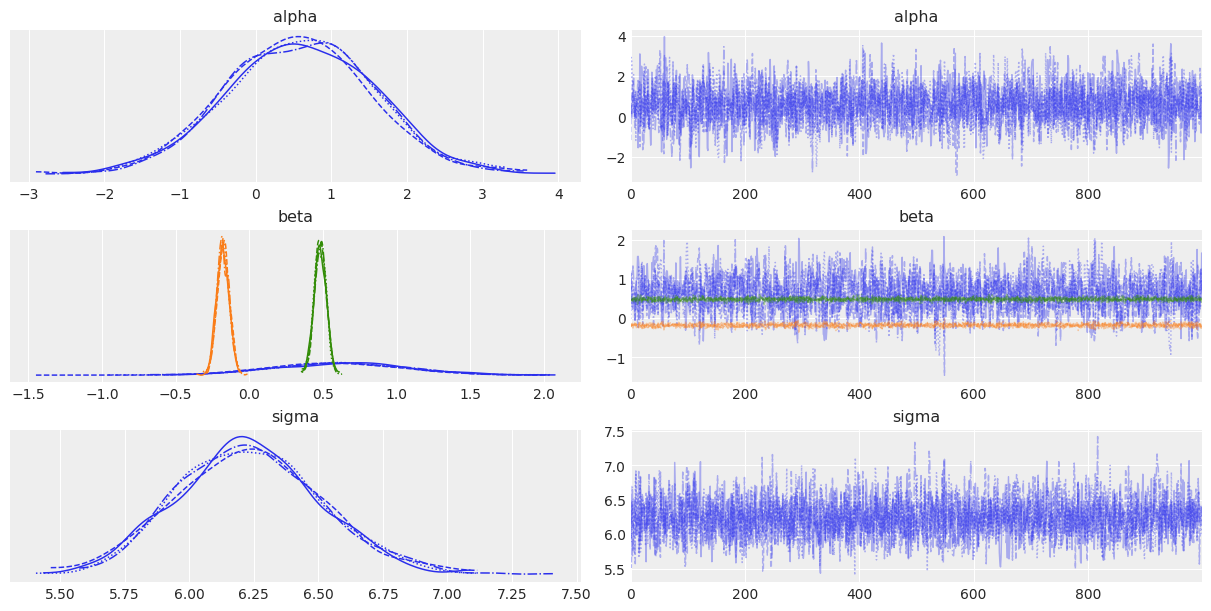

In [21]:
az.plot_trace(idata_1)

Sampling: [siri]


Output()

<Axes: xlabel='siri'>

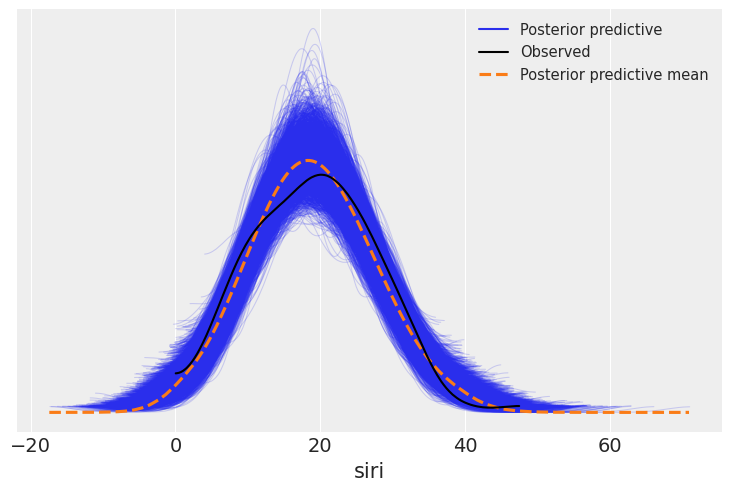

In [22]:
with model_1:
    pm.sample_posterior_predictive(idata_1, extend_inferencedata=True, random_seed=rng)
az.plot_ppc(idata_1)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

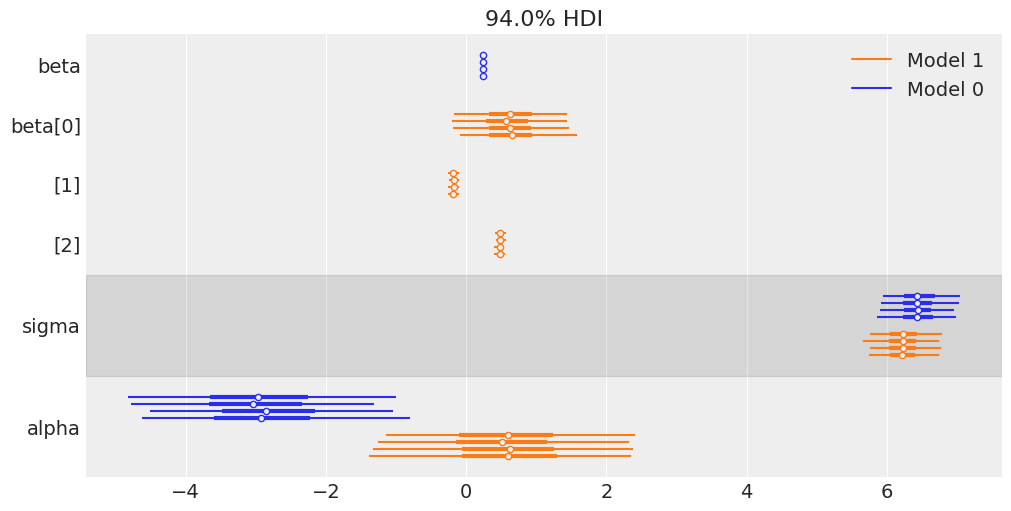

In [23]:
az.plot_forest([idata_0, idata_1], figsize=(10,5))

In [39]:
model_dict = dict(zip(["model_0", "model_1"], [idata_0, idata_1]))
comp = az.compare(model_dict, ic='loo')
comp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_1,0,-817.304326,3.701306,0.000000,0.638251,10.458947,0.000000,False,log
model_0,1,-825.358725,1.878839,8.054399,0.361749,9.980477,8.659744,False,log


In [40]:
ppc_w = az.weight_predictions(
    [model_dict[name] for name in comp.index],
    weights=comp.weight,
)
ppc_w

Inference data with groups:
	> posterior_predictive
	> observed_data

<Axes: >

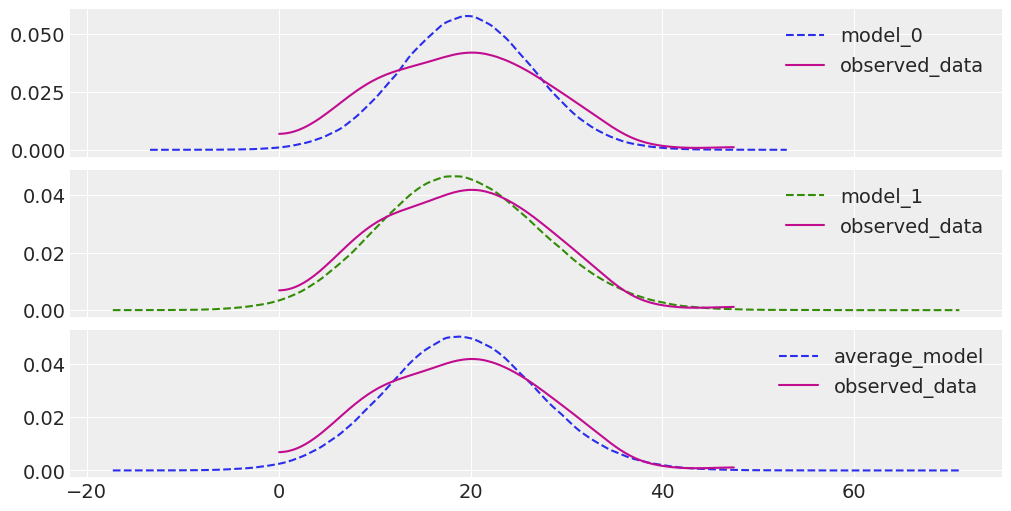

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10,5))
az.plot_kde(
    idata_0.posterior_predictive["siri"].values,
    plot_kwargs={"color": "C0", "linestyle": "--"},
    label="model_0",
    ax=ax1
)
az.plot_kde(
    idata_0.observed_data['siri'].values,
    plot_kwargs={"color": "C3", "linestyle": '-'},
    label="observed_data",
    ax=ax1
)
az.plot_kde(
    idata_1.posterior_predictive["siri"].values,
    plot_kwargs={"color": "C2", "linestyle": "--"},
    label="model_1",
    ax=ax2
)
az.plot_kde(
    idata_0.observed_data['siri'].values,
    plot_kwargs={"color": "C3", "linestyle": '-'},
    label="observed_data",
    ax=ax2
)
az.plot_kde(
    ppc_w.posterior_predictive["siri"].values,
    plot_kwargs={"color": "C0", "linestyle": '--'},
    label="average_model",
    ax=ax3
)
az.plot_kde(
    idata_0.observed_data['siri'].values,
    plot_kwargs={"color": "C3", "linestyle": '-'},
    label="observed_data",
    ax=ax3
)